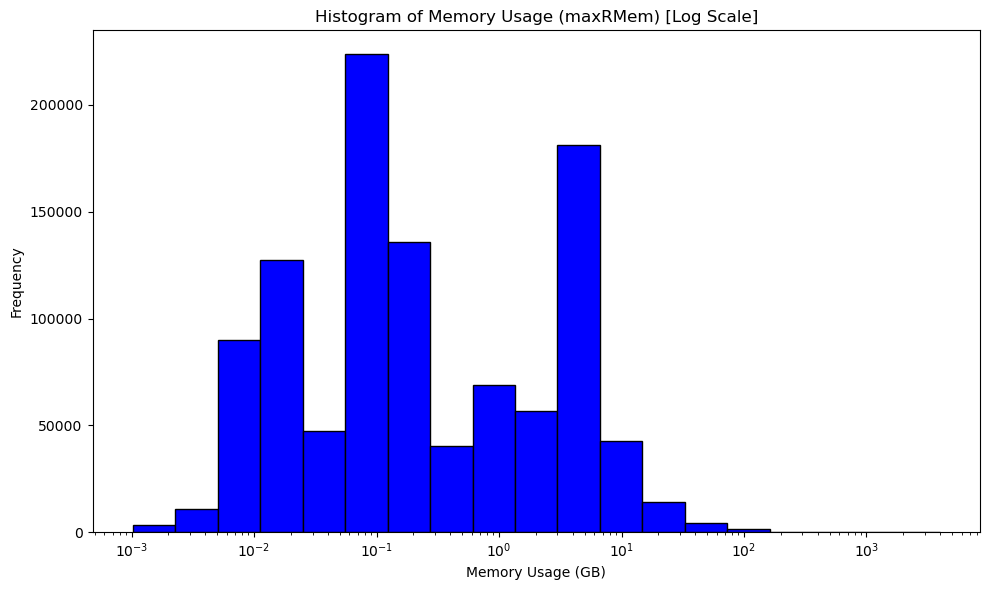

In [64]:
import pymongo
import matplotlib.pyplot as plt
import numpy as np

def mongo_connect(uri):
    try:
        client = pymongo.MongoClient(uri)
    except pymongo.errors.ConfigurationError:
        print("Invalid MongoDB URI")
        exit(1)
    except pymongo.errors.OperationFailure:
        print("Invalid MongoDB credentials")
        exit(1)
    return client

def extract_memory_usage(collection, start_time, end_time):
    # Query to match the submitTime and endTime criteria
    query = {
        "submitTime": { "$gt": start_time },
        "endTime": { "$lte": end_time }
    }
    
    # Extract maxRMem from documents that match the query
    memory_usage = []
    cursor = collection.find(query, {"maxRMem": 1, "_id": 0}).sort("submitTime", pymongo.ASCENDING)
    
    for document in cursor:
        if 'maxRMem' in document:
            # Convert maxRMem from KB to GB
            memory_in_gb = document['maxRMem'] / 1_000_000
            memory_usage.append(memory_in_gb)  # Add the memory usage to the list
    
    return memory_usage

def plot_memory_usage_histogram(memory_usage):
    # Filter out zero values if necessary
    memory_usage = [x for x in memory_usage if x > 0]

    # Plot the histogram of memory usage
    plt.figure(figsize=(10, 6))
    plt.hist(memory_usage, bins=np.logspace(np.log10(min(memory_usage)), np.log10(max(memory_usage)), 20), color='blue', edgecolor='black')
    plt.xscale('log')  # Set x-axis to log scale
    
    plt.title('Histogram of Memory Usage (maxRMem) [Log Scale]')
    plt.xlabel('Memory Usage (GB)')
    plt.ylabel('Frequency')
    plt.tight_layout()  # Adjust layout to prevent overlap

    plt.savefig('mem_usage.png', format = 'png')
    
    plt.show()

if __name__ == "__main__":
    # Define the start and end times as UNIX timestamps
    start_time = 1724043600
    end_time = 1724648400
    
    client = mongo_connect("mongodb://localhost:27017")
    db = client['lsf']
    collection = db['finished_jobs']
    
    # Extract memory usage from the documents within the time range
    memory_usage = extract_memory_usage(collection, start_time, end_time)
    
    # Plot the histogram of memory usage
    plot_memory_usage_histogram(memory_usage)


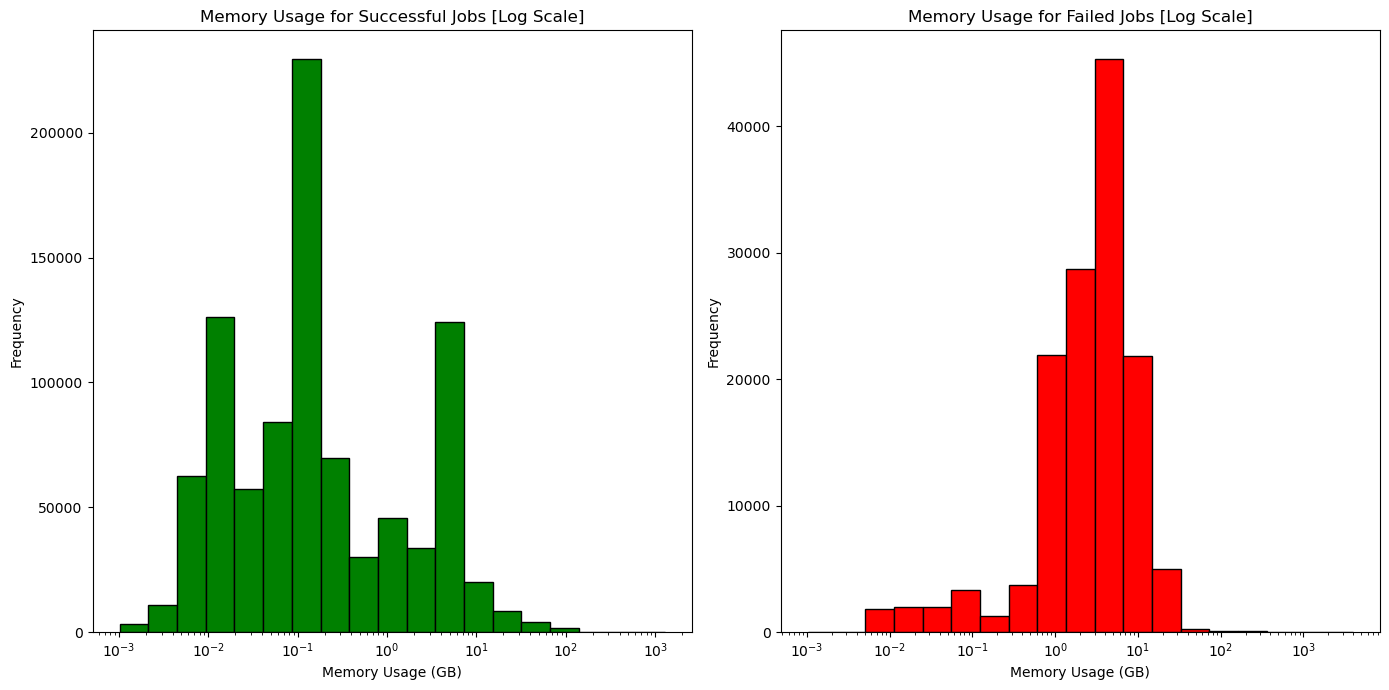

In [63]:
import pymongo
import matplotlib.pyplot as plt
import numpy as np

def mongo_connect(uri):
    try:
        client = pymongo.MongoClient(uri)
    except pymongo.errors.ConfigurationError:
        print("Invalid MongoDB URI")
        exit(1)
    except pymongo.errors.OperationFailure:
        print("Invalid MongoDB credentials")
        exit(1)
    return client

def extract_memory_usage_by_jstatus(collection, start_time, end_time):
    # Query to match the submitTime and endTime criteria
    query = {
        "submitTime": { "$gt": start_time },
        "endTime": { "$lte": end_time }
    }
    
    # Extract memory usage (maxRMem) and group by jStatus
    success_memory_usage = []
    failure_memory_usage = []
    
    # Fetch maxRMem and jStatus fields
    cursor = collection.find(query, {"maxRMem": 1, "jStatus": 1, "_id": 0}).sort("submitTime", pymongo.ASCENDING)
    
    for document in cursor:
        if 'maxRMem' in document and 'jStatus' in document:
            # Convert maxRMem from KB to GB
            memory_in_gb = document['maxRMem'] / 1_000_000
            if document['jStatus'] == 'done':
                success_memory_usage.append(memory_in_gb)  # Success job memory usage
            else:
                failure_memory_usage.append(memory_in_gb)  # Failed job memory usage
    
    return success_memory_usage, failure_memory_usage

def plot_memory_usage_histograms(success_memory_usage, failure_memory_usage):
    plt.figure(figsize=(14, 7))

    # Filter out zero values
    success_memory_usage = [x for x in success_memory_usage if x > 0]
    failure_memory_usage = [x for x in failure_memory_usage if x > 0]

    if success_memory_usage:
        plt.subplot(1, 2, 1)
        plt.hist(success_memory_usage, bins=np.logspace(np.log10(min(success_memory_usage)), np.log10(max(success_memory_usage)), 20), color='green', edgecolor='black')
        plt.xscale('log')  # Set x-axis to log scale
        plt.title('Memory Usage for Successful Jobs [Log Scale]')
        plt.xlabel('Memory Usage (GB)')
        plt.ylabel('Frequency')

    if failure_memory_usage:
        plt.subplot(1, 2, 2)
        plt.hist(failure_memory_usage, bins=np.logspace(np.log10(min(failure_memory_usage)), np.log10(max(failure_memory_usage)), 20), color='red', edgecolor='black')
        plt.xscale('log')  # Set x-axis to log scale
        plt.title('Memory Usage for Failed Jobs [Log Scale]')
        plt.xlabel('Memory Usage (GB)')
        plt.ylabel('Frequency')

    plt.tight_layout()  # Adjust layout to prevent overlap

    plt.savefig('mem_usage_by_jobStatus.png', format = 'png')
    
    plt.show()

if __name__ == "__main__":
    start_time = 1724043600  # Define the start time
    end_time = 1724648400  # Define the end time
    
    client = mongo_connect("mongodb://localhost:27017")
    db = client['lsf']
    collection = db['finished_jobs']
    
    # Extract memory usage grouped by jStatus
    success_memory_usage, failure_memory_usage = extract_memory_usage_by_jstatus(collection, start_time, end_time)
    
    # Plot the histograms
    plot_memory_usage_histograms(success_memory_usage, failure_memory_usage)


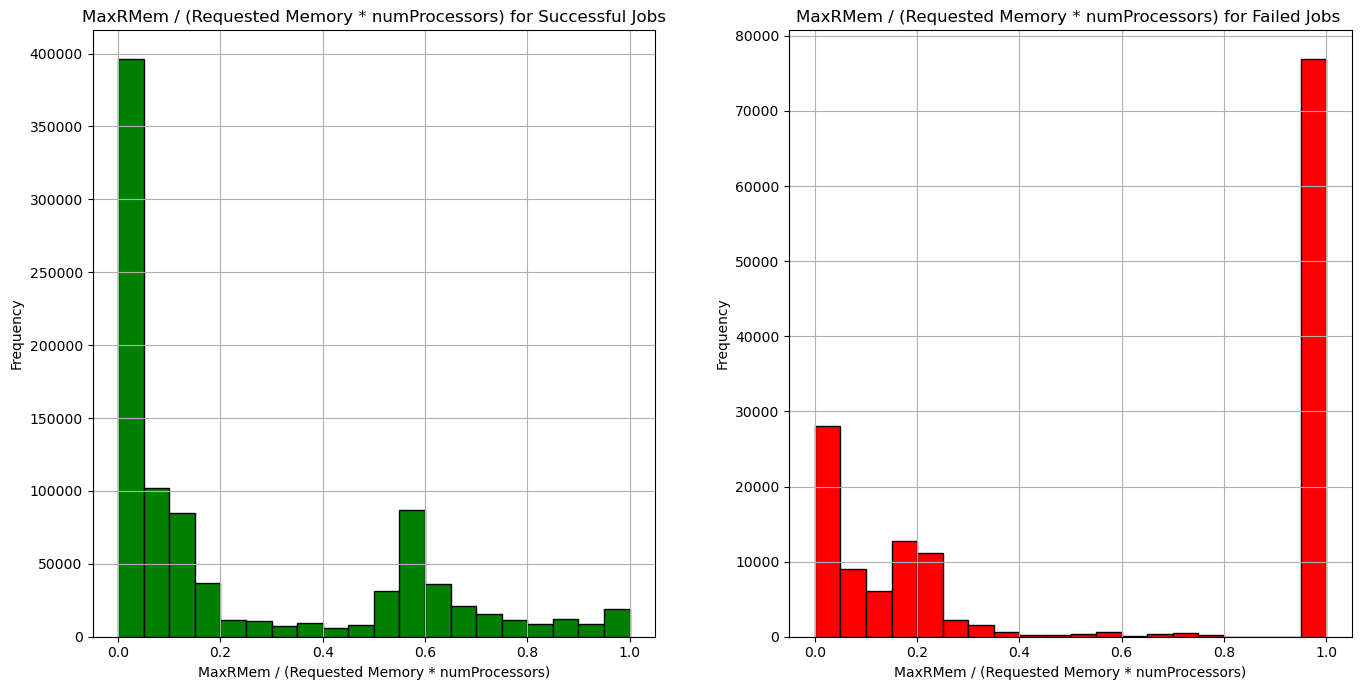

In [83]:
import pymongo
import matplotlib.pyplot as plt
import numpy as np
import re

def mongo_connect(uri):
    try:
        client = pymongo.MongoClient(uri)
    except pymongo.errors.ConfigurationError:
        print("Invalid MongoDB URI")
        exit(1)
    except pymongo.errors.OperationFailure:
        print("Invalid MongoDB credentials")
        exit(1)
    return client

def extract_memory_ratios(collection, start_time, end_time):
    # Query to match the submitTime and endTime criteria
    query = {
        "submitTime": { "$gt": start_time },
        "endTime": { "$lte": end_time }
    }
    
    # Extract the ratio of maxRMem to (requestedMemory * numProcessors) and group by jStatus
    success_ratios = []
    failure_ratios = []

    # Regular expression to extract the memory value from the resReq field
    mem_pattern = re.compile(r"mem=(\d+\.?\d*)")

    # Fetch maxRMem, resReq, numProcessors, and jStatus fields
    cursor = collection.find(query, {"maxRMem": 1, "resReq": 1, "numProcessors": 1, "jStatus": 1, "_id": 0}).sort("submitTime", pymongo.ASCENDING)

    for document in cursor:
        if 'maxRMem' in document and 'resReq' in document and 'numProcessors' in document:
            max_rmem = document['maxRMem']
            res_req = document['resReq']
            num_processors = document['numProcessors']

            # Parse the requested memory from the resReq field
            match = mem_pattern.search(res_req)
            if match:
                requested_mem = float(match.group(1))  # Requested memory is in MB
            
                if requested_mem > 0:  # Avoid division by zero
                    # Adjust requested memory for the number of processors (still in MB)
                    requested_mem_adjusted = requested_mem * num_processors
                    
                    # Convert requested memory to KB
                    requested_mem_adjusted_kb = requested_mem_adjusted * 1024
                    
                    # Calculate the memory ratio
                    memory_ratio = max_rmem / requested_mem_adjusted_kb  # Convert requested memory to KB
                    
                    # Constrain memory ratio values to a maximum of 1
                    constrained_memory_ratio = min(memory_ratio, 1)
            
                    if 'jStatus' in document:
                        if document['jStatus'] == 'done':
                            success_ratios.append(constrained_memory_ratio)  # Success job memory ratio
                        else:
                            failure_ratios.append(constrained_memory_ratio)  # Failed job memory ratio

    return success_ratios, failure_ratios

def plot_memory_ratio_histograms(success_ratios, failure_ratios):
    plt.figure(figsize=(14, 7))

    if success_ratios:  # Check if list is not empty
        plt.subplot(1, 2, 1)
        bins = np.linspace(0, 1, 21)  # Use linear bins between 0 and 1
        plt.hist(success_ratios, bins=bins, color='green', edgecolor='black')
        plt.title('MaxRMem / (Requested Memory * numProcessors) for Successful Jobs')
        plt.xlabel('MaxRMem / (Requested Memory * numProcessors)')
        plt.ylabel('Frequency')
        plt.grid(True)

    if failure_ratios:  # Check if list is not empty
        plt.subplot(1, 2, 2)
        bins = np.linspace(0, 1, 21)  # Use linear bins between 0 and 1
        plt.hist(failure_ratios, bins=bins, color='red', edgecolor='black')
        plt.title('MaxRMem / (Requested Memory * numProcessors) for Failed Jobs ')
        plt.xlabel('MaxRMem / (Requested Memory * numProcessors)')
        plt.ylabel('Frequency')
        plt.grid(True)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.savefig('mem_efficiency_by_jobStatus.png', format='png')
    plt.show()

if __name__ == "__main__":
    start_time = 1724043600  # Define the start time
    end_time = 1724648400    # Define the end time
    
    client = mongo_connect("mongodb://localhost:27017")
    db = client['lsf']
    collection = db['finished_jobs']
    
    # Extract the memory ratios grouped by jStatus
    success_ratios, failure_ratios = extract_memory_ratios(collection, start_time, end_time)
    
    # Plot the histograms
    plot_memory_ratio_histograms(success_ratios, failure_ratios)


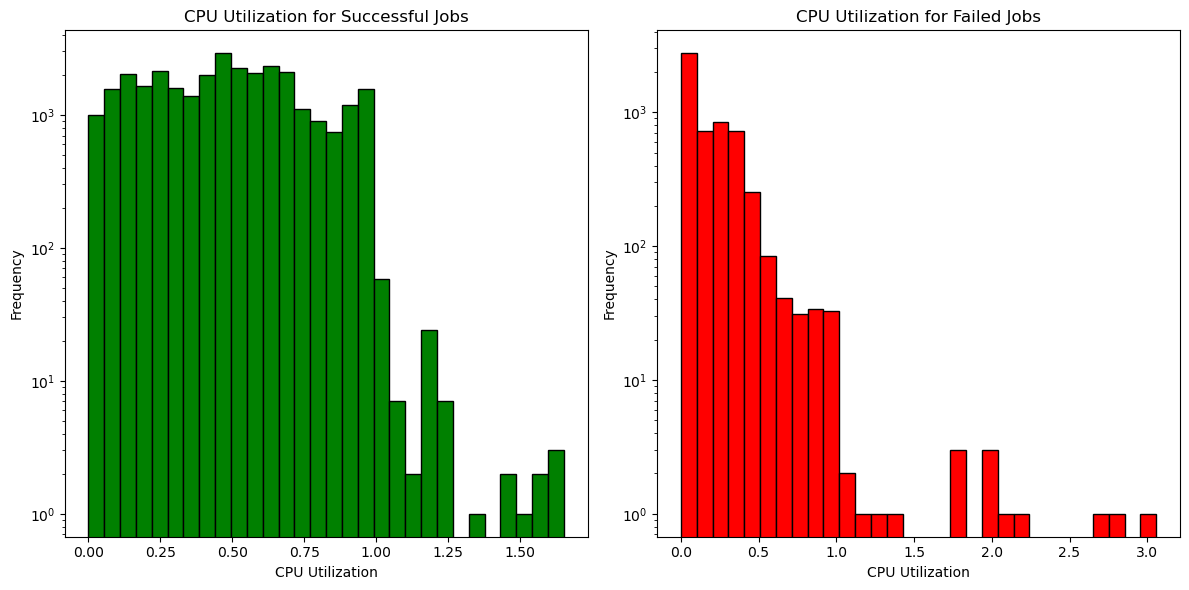

In [60]:
import pymongo
import matplotlib.pyplot as plt
import numpy as np

def mongo_connect(uri):
    try:
        client = pymongo.MongoClient(uri)
    except pymongo.errors.ConfigurationError:
        print("Invalid MongoDB URI")
        exit(1)
    except pymongo.errors.OperationFailure:
        print("Invalid MongoDB credentials")
        exit(1)
    return client

def extract_cpu_utilization_by_status(collection, start_time, end_time):
    # Query to match the submitTime and endTime criteria
    query = {
        "submitTime": { "$gt": start_time },
        "endTime": { "$lte": end_time }
    }
    
    success_utilizations = []
    failure_utilizations = []

    # Fetch cpuTime, numProcessors, runTime, and jStatus fields
    cursor = collection.find(query, {"cpuTime": 1, "numProcessors": 1, "runTime": 1, "jStatus": 1, "_id": 0}).sort("submitTime", pymongo.ASCENDING)

    for document in cursor:
        if 'cpuTime' in document and 'numProcessors' in document and 'runTime' in document and 'jStatus' in document:
            cpu_time = document['cpuTime']
            num_processors = document['numProcessors']
            run_time = document['runTime']
            j_status = document['jStatus']

            if num_processors > 1 and run_time > 0:  # Avoid division by zero and exclude jobs with exactly 1 processor
                cpu_utilization = cpu_time / (num_processors * run_time)
                
                if j_status == 'done':
                    success_utilizations.append(cpu_utilization)
                else:
                    failure_utilizations.append(cpu_utilization)

    return success_utilizations, failure_utilizations

def plot_cpu_utilization_histograms(success_utilizations, failure_utilizations):
    plt.figure(figsize=(12, 6))

    if success_utilizations:  # Check if list is not empty
        plt.subplot(1, 2, 1)
        plt.hist(success_utilizations, bins=30, color='green', edgecolor='black')
        plt.title('CPU Utilization for Successful Jobs')
        plt.xlabel('CPU Utilization')
        plt.ylabel('Frequency')
        plt.yscale('log')  # Use logarithmic scale for better visualization if needed

    if failure_utilizations:  # Check if list is not empty
        plt.subplot(1, 2, 2)
        plt.hist(failure_utilizations, bins=30, color='red', edgecolor='black')
        plt.title('CPU Utilization for Failed Jobs')
        plt.xlabel('CPU Utilization')
        plt.ylabel('Frequency')
        plt.yscale('log')  # Use logarithmic scale for better visualization if needed

    plt.tight_layout()  # Adjust layout to prevent overlap

    plt.savefig('cpu_utilization_by_jobStatus.png', format = 'png')
    
    plt.show()

if __name__ == "__main__":
    start_time = 1724043600  # Define the start time
    end_time = 1724648400  # Define the end time
    
    client = mongo_connect("mongodb://localhost:27017")
    db = client['lsf']
    collection = db['finished_jobs']
    
    # Extract CPU utilization for each job and separate by status
    success_utilizations, failure_utilizations = extract_cpu_utilization_by_status(collection, start_time, end_time)
    
    # Plot the histograms
    plot_cpu_utilization_histograms(success_utilizations, failure_utilizations)


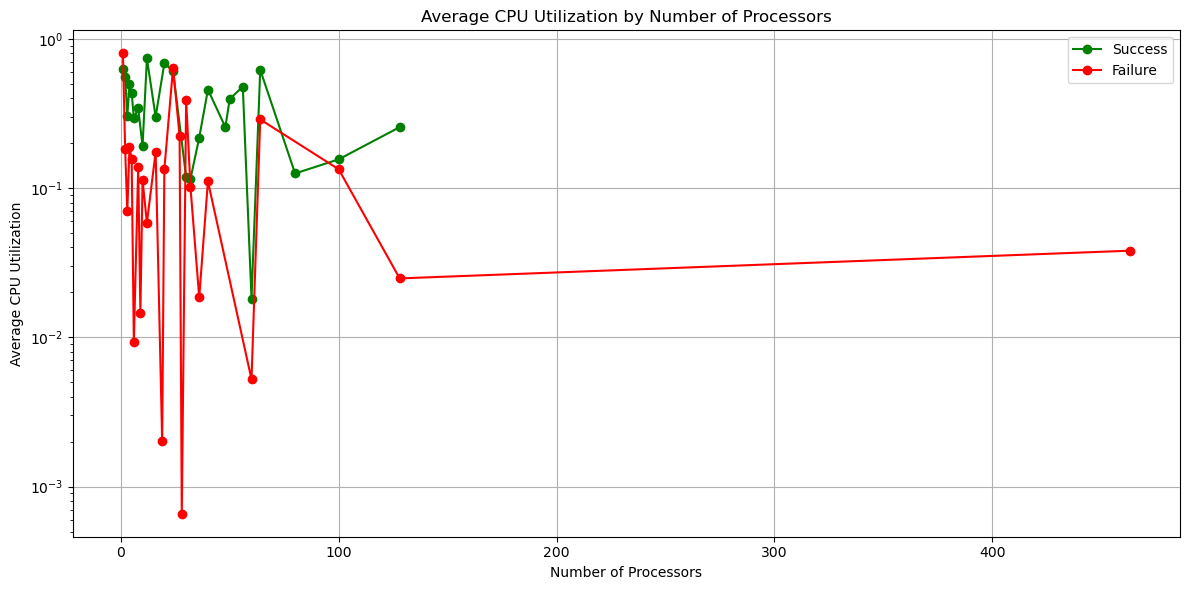

In [59]:
import pymongo
import matplotlib.pyplot as plt
import pandas as pd

def mongo_connect(uri):
    try:
        client = pymongo.MongoClient(uri)
    except pymongo.errors.ConfigurationError:
        print("Invalid MongoDB URI")
        exit(1)
    except pymongo.errors.OperationFailure:
        print("Invalid MongoDB credentials")
        exit(1)
    return client

def extract_cpu_utilization_by_status(collection, start_time, end_time):
    # Query to match the submitTime and endTime criteria
    query = {
        "submitTime": { "$gt": start_time },
        "endTime": { "$lte": end_time }
    }
    
    success_data = []
    failure_data = []

    cursor = collection.find(query, {"cpuTime": 1, "numProcessors": 1, "runTime": 1, "exitStatus": 1, "_id": 0})

    for document in cursor:
        if 'cpuTime' in document and 'numProcessors' in document and 'runTime' in document and 'exitStatus' in document:
            cpu_time = document['cpuTime']
            num_processors = document['numProcessors']
            run_time = document['runTime']
            exit_status = document['exitStatus']

            if num_processors > 0 and run_time > 0:  # Avoid division by zero
                cpu_utilization = cpu_time / (num_processors * run_time)
                
                if exit_status == 0:
                    success_data.append((num_processors, cpu_utilization))
                else:
                    failure_data.append((num_processors, cpu_utilization))

    return success_data, failure_data

def plot_cpu_utilization_by_processors(success_data, failure_data):
    # Convert to DataFrame for easier manipulation
    success_df = pd.DataFrame(success_data, columns=['numProcessors', 'cpuUtilization'])
    failure_df = pd.DataFrame(failure_data, columns=['numProcessors', 'cpuUtilization'])

    # Group by number of processors and calculate average CPU utilization
    success_grouped = success_df.groupby('numProcessors').mean().reset_index()
    failure_grouped = failure_df.groupby('numProcessors').mean().reset_index()

    # Plot
    plt.figure(figsize=(12, 6))
    
    # Plot for successful jobs
    plt.plot(success_grouped['numProcessors'], success_grouped['cpuUtilization'], marker='o', linestyle='-', color='green', label='Success')
    
    # Plot for failed jobs
    plt.plot(failure_grouped['numProcessors'], failure_grouped['cpuUtilization'], marker='o', linestyle='-', color='red', label='Failure')
    
    plt.title('Average CPU Utilization by Number of Processors')
    plt.xlabel('Number of Processors')
    plt.ylabel('Average CPU Utilization')
    plt.yscale('log')  # Use logarithmic scale for better visualization if needed
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # Save the plot to the current folder
    plt.savefig('cpu_utilization_by_processors.png', format='png')

    # Show the plot (optional)
    plt.show()

if __name__ == "__main__":
    start_time = 1724043600  # Define the start time
    end_time = 1724648400  # Define the end time
    
    client = mongo_connect("mongodb://localhost:27017")
    db = client['lsf']
    
    collection = db['finished_jobs']
    
    # Extract CPU utilization data separated by job status
    success_data, failure_data = extract_cpu_utilization_by_status(collection, start_time, end_time)
    
    # Plot CPU utilization by number of processors
    plot_cpu_utilization_by_processors(success_data, failure_data)


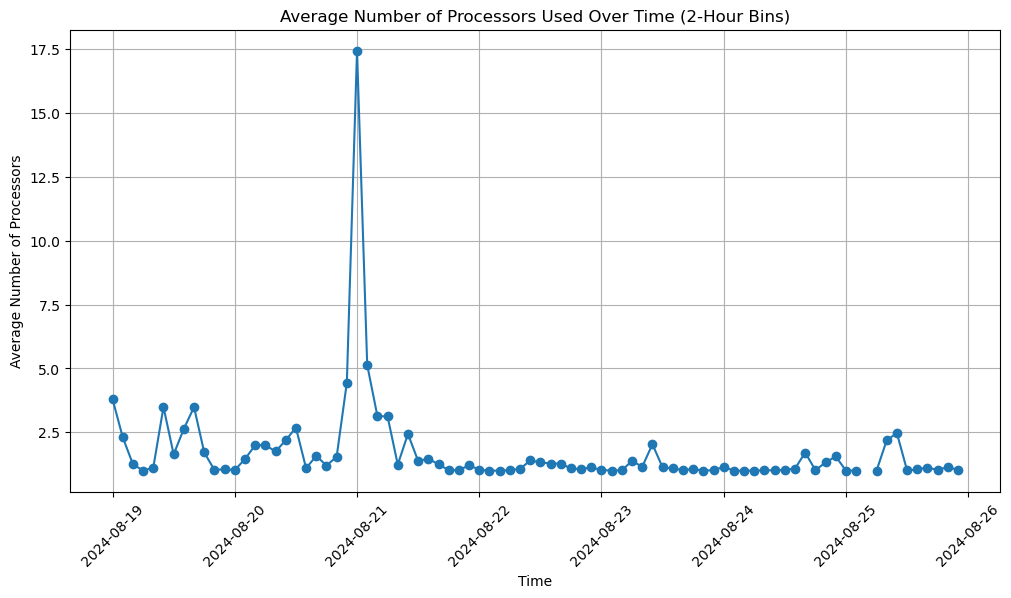

In [58]:
import pymongo
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import pytz

def mongo_connect(uri):
    try:
        client = pymongo.MongoClient(uri)
    except pymongo.errors.ConfigurationError:
        print("Invalid MongoDB URI")
        exit(1)
    except pymongo.errors.OperationFailure:
        print("Invalid MongoDB credentials")
        exit(1)
    return client

def extract_data_by_time(collection, start_time, end_time):
    # Corrected query structure with both $gte and $lte under 'submitTime'
    query = {
        "submitTime": { 
            "$gte": start_time,
            "$lte": end_time
        }
    }
    
    data = []
    cursor = collection.find(query, {"submitTime": 1, "numProcessors": 1, "_id": 0}).sort("submitTime", pymongo.ASCENDING)

    for document in cursor:
        if 'submitTime' in document and 'numProcessors' in document:
            data.append({
                'submitTime': document['submitTime'],
                'numProcessors': document['numProcessors']
            })

    return data

def process_and_plot_data(data):
    # Convert list of dicts to DataFrame
    df = pd.DataFrame(data)

    # Convert 'submitTime' from epoch to datetime in CST
    df['submitTime'] = pd.to_datetime(df['submitTime'], unit='s')
    df['submitTime'] = df['submitTime'].dt.tz_localize('UTC').dt.tz_convert('America/Chicago')

    # Set 'submitTime' as the index
    df.set_index('submitTime', inplace=True)

    # Resample data into 3-hour intervals and calculate the mean number of processors used
    df_resampled = df.resample('2H').mean()

    # Plot the average number of processors used over time
    plt.figure(figsize=(12, 6))
    plt.plot(df_resampled.index, df_resampled['numProcessors'], marker='o', linestyle='-')
    plt.title('Average Number of Processors Used Over Time (2-Hour Bins)')
    plt.xlabel('Time')
    plt.ylabel('Average Number of Processors')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout

    plt.savefig('processors_over_time.png', format='png')
    
    plt.show()

if __name__ == "__main__":
    start_time = 1724043600  # Define the start time
    end_time = 1724648400    # Define the end time
    
    client = mongo_connect("mongodb://localhost:27017")
    db = client['lsf']
    collection = db['finished_jobs']
    
    # Extract data from MongoDB
    data = extract_data_by_time(collection, start_time, end_time)
    
    # Process and plot the data
    process_and_plot_data(data)


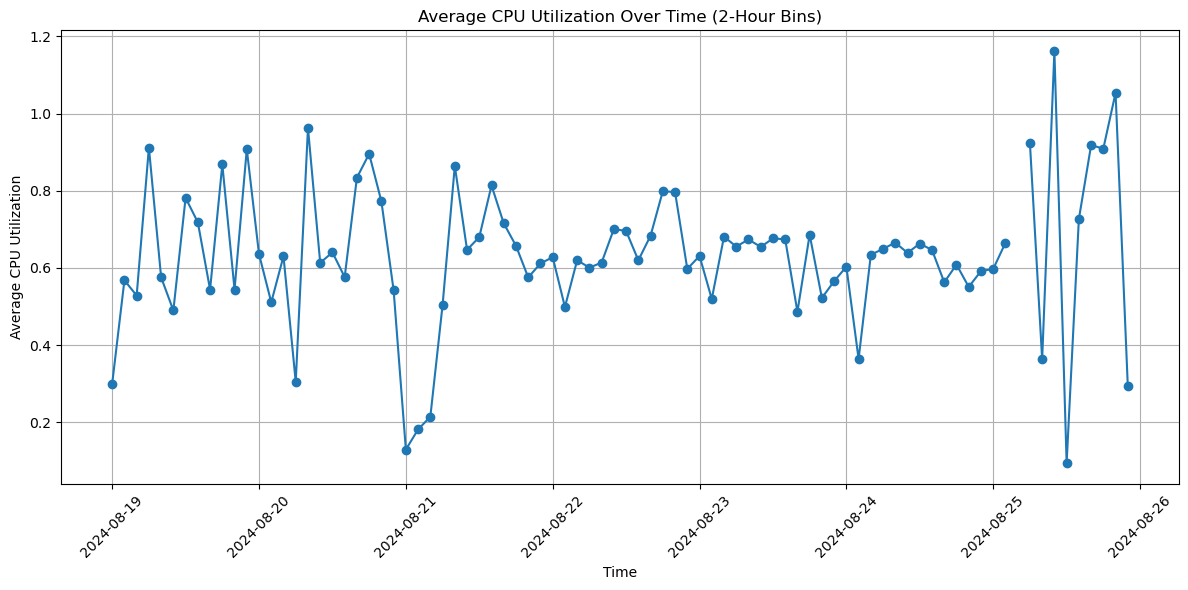

In [57]:
import pymongo
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import pytz

def mongo_connect(uri):
    try:
        client = pymongo.MongoClient(uri)
    except pymongo.errors.ConfigurationError:
        print("Invalid MongoDB URI")
        exit(1)
    except pymongo.errors.OperationFailure:
        print("Invalid MongoDB credentials")
        exit(1)
    return client

def extract_data_by_time(collection, start_time, end_time):
    # Correct query structure with both $gte and $lte under 'submitTime'
    query = {
        "submitTime": { 
            "$gte": start_time,
            "$lte": end_time
        }
    }
    
    # Extract cpuTime, numProcessors, and runTime
    data = []
    cursor = collection.find(query, {"submitTime": 1, "cpuTime": 1, "numProcessors": 1, "runTime": 1, "_id": 0}).sort("submitTime", pymongo.ASCENDING)

    for document in cursor:
        if 'submitTime' in document and 'cpuTime' in document and 'numProcessors' in document and 'runTime' in document:
            # Avoid division by zero for runtime and processors
            if document['runTime'] > 0 and document['numProcessors'] > 0:
                cpu_utilization = document['cpuTime'] / (document['numProcessors'] * document['runTime'])
                data.append({
                    'submitTime': document['submitTime'],
                    'cpuUtilization': cpu_utilization
                })

    return data

def process_and_plot_data(data):
    # Convert list of dicts to DataFrame
    df = pd.DataFrame(data)

    # Convert 'submitTime' from epoch to datetime in CST
    df['submitTime'] = pd.to_datetime(df['submitTime'], unit='s')
    df['submitTime'] = df['submitTime'].dt.tz_localize('UTC').dt.tz_convert('America/Chicago')

    # Set 'submitTime' as the index
    df.set_index('submitTime', inplace=True)

    # Resample data into 3-hour intervals and calculate the mean CPU utilization
    df_resampled = df.resample('2H').mean()

    # Plot the average CPU utilization over time
    plt.figure(figsize=(12, 6))
    plt.plot(df_resampled.index, df_resampled['cpuUtilization'], marker='o', linestyle='-')
    plt.title('Average CPU Utilization Over Time (2-Hour Bins)')
    plt.xlabel('Time')
    plt.ylabel('Average CPU Utilization')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.savefig('cpu_utilization_over_time.png', format='png')
    
    plt.show()

if __name__ == "__main__":
    start_time = 1724043600  # Define the start time
    end_time = 1724648400    # Define the end time
    
    client = mongo_connect("mongodb://localhost:27017")
    db = client['lsf']
    collection = db['finished_jobs']
    
    # Extract data from MongoDB
    data = extract_data_by_time(collection, start_time, end_time)
    
    # Process and plot the data
    process_and_plot_data(data)


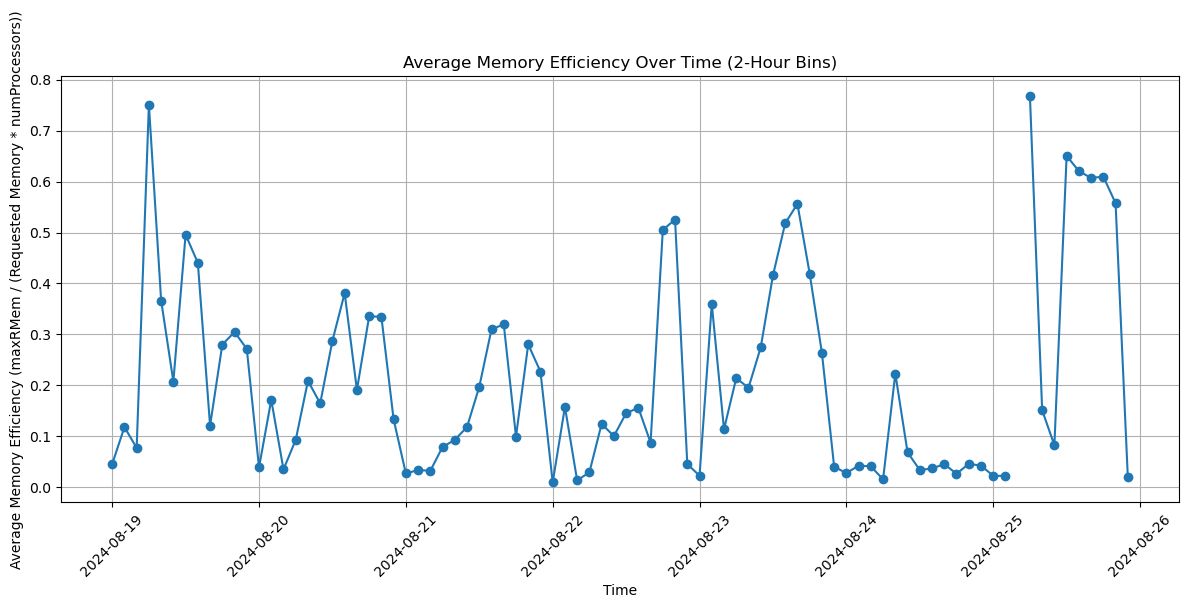

In [84]:
import pymongo
import matplotlib.pyplot as plt
import pandas as pd
import re
from datetime import datetime
import pytz

def mongo_connect(uri):
    try:
        client = pymongo.MongoClient(uri)
    except pymongo.errors.ConfigurationError:
        print("Invalid MongoDB URI")
        exit(1)
    except pymongo.errors.OperationFailure:
        print("Invalid MongoDB credentials")
        exit(1)
    return client

def extract_memory_efficiency_by_time(collection, start_time, end_time):
    # Query to match the submitTime and endTime criteria
    query = {
        "submitTime": { "$gte": start_time },
        "endTime": { "$lte": end_time }
    }
    
    # Extract maxRMem, resReq, and numProcessors for memory efficiency calculation
    data = []
    
    # Regular expression to extract the memory value from the resReq field
    mem_pattern = re.compile(r"mem=(\d+\.?\d*)")

    # Fetch maxRMem, resReq, and numProcessors fields
    cursor = collection.find(query, {"submitTime": 1, "maxRMem": 1, "resReq": 1, "numProcessors": 1, "_id": 0}).sort("submitTime", pymongo.ASCENDING)

    for document in cursor:
        if 'maxRMem' in document and 'resReq' in document and 'numProcessors' in document:
            max_rmem = document['maxRMem']
            res_req = document['resReq']
            num_processors = document['numProcessors']

            # Parse the requested memory from the resReq field
            match = mem_pattern.search(res_req)
            if match:
                requested_mem = float(match.group(1))  # Requested memory is in MB

                if requested_mem > 0:  # Avoid division by zero
                    # Adjust requested memory for the number of processors
                    requested_mem_adjusted = requested_mem * num_processors

                    memory_efficiency = max_rmem / (requested_mem_adjusted * 1024)  # Convert requested memory to KB
                    
                    # Constrain memory efficiency values to a maximum of 1
                    constrained_memory_efficiency = min(memory_efficiency, 1)

                    data.append({
                        'submitTime': document['submitTime'],
                        'memoryEfficiency': constrained_memory_efficiency
                    })

    return data

def process_and_plot_memory_efficiency(data):
    # Convert list of dicts to DataFrame
    df = pd.DataFrame(data)

    # Convert 'submitTime' from epoch to datetime in CST
    df['submitTime'] = pd.to_datetime(df['submitTime'], unit='s')
    df['submitTime'] = df['submitTime'].dt.tz_localize('UTC').dt.tz_convert('America/Chicago')

    # Set 'submitTime' as the index
    df.set_index('submitTime', inplace=True)

    # Resample data into 2-hour intervals and calculate the mean memory efficiency
    df_resampled = df.resample('2H').mean()

    # Plot the average memory efficiency over time
    plt.figure(figsize=(12, 6))
    plt.plot(df_resampled.index, df_resampled['memoryEfficiency'], marker='o', linestyle='-')
    plt.title('Average Memory Efficiency Over Time (2-Hour Bins)')
    plt.xlabel('Time')
    plt.ylabel('Average Memory Efficiency (maxRMem / (Requested Memory * numProcessors))')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.savefig('mem_efficiency_over_time.png', format='png')
    
    plt.show()

if __name__ == "__main__":
    start_time = 1724043600  # Define the start time
    end_time = 1724648400    # Define the end time
    
    client = mongo_connect("mongodb://localhost:27017")
    db = client['lsf']
    collection = db['finished_jobs']
    
    # Extract the memory efficiency data
    data = extract_memory_efficiency_by_time(collection, start_time, end_time)
    
    # Process and plot the data
    process_and_plot_memory_efficiency(data)


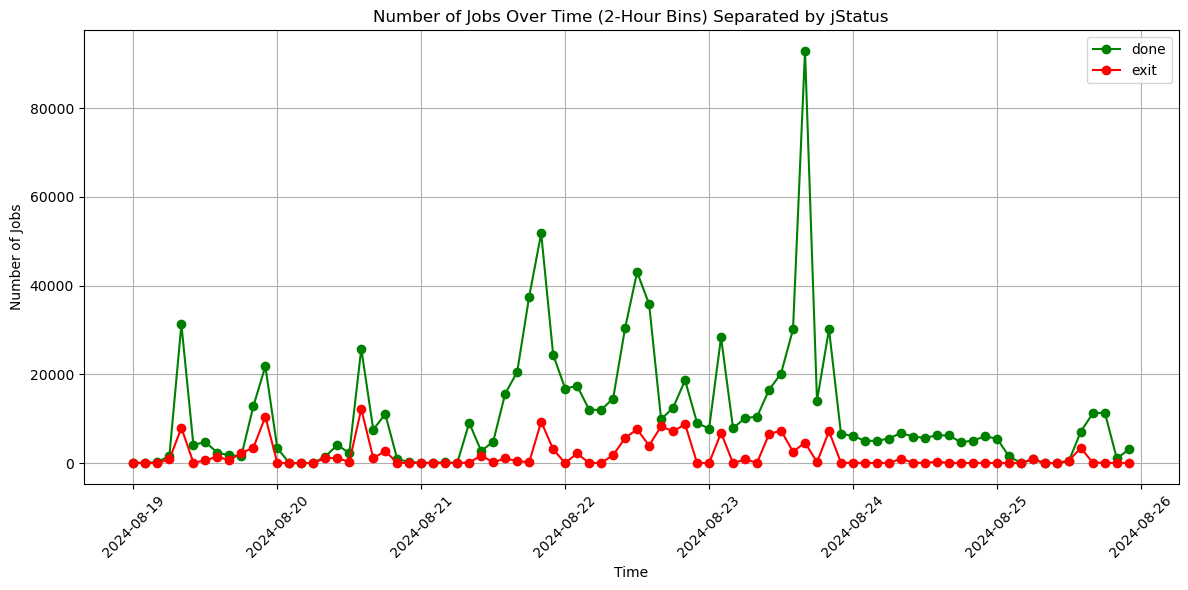

In [55]:
import pymongo
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import pytz

def mongo_connect(uri):
    try:
        client = pymongo.MongoClient(uri)
    except pymongo.errors.ConfigurationError:
        print("Invalid MongoDB URI")
        exit(1)
    except pymongo.errors.OperationFailure:
        print("Invalid MongoDB credentials")
        exit(1)
    return client

def extract_job_counts_by_time(collection, start_time, end_time):
    # Query to match the submitTime and endTime criteria
    query = {
        "submitTime": { "$gte": start_time },
        "endTime": { "$lte": end_time }
    }
    
    # Extract submitTime and jStatus fields
    data = []
    cursor = collection.find(query, {"submitTime": 1, "jStatus": 1, "_id": 0}).sort("submitTime", pymongo.ASCENDING)

    for document in cursor:
        if 'submitTime' in document and 'jStatus' in document:
            data.append({
                'submitTime': document['submitTime'],
                'jStatus': document['jStatus']
            })

    return data

def process_and_plot_job_counts(data):
    # Convert list of dicts to DataFrame
    df = pd.DataFrame(data)

    # Convert 'submitTime' from epoch to datetime in CST
    df['submitTime'] = pd.to_datetime(df['submitTime'], unit='s')
    df['submitTime'] = df['submitTime'].dt.tz_localize('UTC').dt.tz_convert('America/Chicago')

    # Set 'submitTime' as the index
    df.set_index('submitTime', inplace=True)

    # Separate data by 'jStatus'
    df_done = df[df['jStatus'] == 'done']
    df_exit = df[df['jStatus'] == 'exit']

    # Resample data into 3-hour intervals and count the number of jobs
    df_done_resampled = df_done.resample('2H').count()
    df_exit_resampled = df_exit.resample('2H').count()

    # Plot the number of jobs over time for 'done' and 'exit' statuses
    plt.figure(figsize=(12, 6))
    plt.plot(df_done_resampled.index, df_done_resampled['jStatus'], marker='o', linestyle='-', label='done', color='green')
    plt.plot(df_exit_resampled.index, df_exit_resampled['jStatus'], marker='o', linestyle='-', label='exit', color='red')

    # Add plot title and labels
    plt.title('Number of Jobs Over Time (2-Hour Bins) Separated by jStatus')
    plt.xlabel('Time')
    plt.ylabel('Number of Jobs')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()

    plt.savefig('job_counts_over_time.png', format='png')
    
    plt.show()

if __name__ == "__main__":
    start_time = 1724043600  # Define the start time
    end_time = 1724648400  # Define the end time
    
    client = mongo_connect("mongodb://localhost:27017")
    db = client['lsf']
    collection = db['finished_jobs']
    
    # Extract the job count data by jStatus
    data = extract_job_counts_by_time(collection, start_time, end_time)
    
    # Process and plot the data
    process_and_plot_job_counts(data)


Contingency Table:
High CPU Utilization   False   True 
Job Status                          
done                  514802  409000
failed                 29526  110937


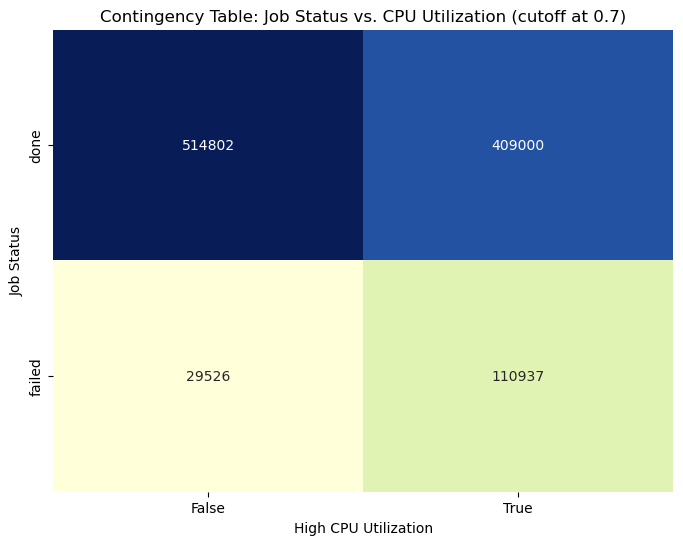

Chi-squared statistic: 58772.89880733256
p-value: 0.0
Degrees of freedom: 1
Expected frequencies:
[[472486.92295246 451315.07704754]
 [ 71841.07704754  68621.92295246]]


In [72]:
import pymongo
import pandas as pd
from scipy.stats import fisher_exact

def mongo_connect(uri):
    try:
        client = pymongo.MongoClient(uri)
    except pymongo.errors.ConfigurationError:
        print("Invalid MongoDB URI")
        exit(1)
    except pymongo.errors.OperationFailure:
        print("Invalid MongoDB credentials")
        exit(1)
    return client

def extract_cpu_utilization_by_status(collection, start_time, end_time):
    query = {
        "submitTime": { "$gte": start_time },
        "endTime": { "$lte": end_time }
    }
    
    data = []

    cursor = collection.find(query, {"cpuTime": 1, "numProcessors": 1, "runTime": 1, "exitStatus": 1, "_id": 0})

    for document in cursor:
        if 'cpuTime' in document and 'numProcessors' in document and 'runTime' in document and 'exitStatus' in document:
            cpu_time = document['cpuTime']
            num_processors = document['numProcessors']
            run_time = document['runTime']
            exit_status = document['exitStatus']

            if num_processors > 0 and run_time > 0:  # Avoid division by zero
                cpu_utilization = cpu_time / (num_processors * run_time)
                status = 'done' if exit_status == 0 else 'failed'
                data.append({'cpuUtilization': cpu_utilization, 'jStatus': status})

    return data

def create_contingency_table(data, cutoff=0.7):
    # Convert to DataFrame
    df = pd.DataFrame(data)
    
    # Categorize CPU Utilization
    df['cpuUtilizationCategory'] = df['cpuUtilization'] >= cutoff
    
    # Create a contingency table
    contingency_table = pd.crosstab(df['jStatus'], df['cpuUtilizationCategory'], rownames=['Job Status'], colnames=['High CPU Utilization'])
    
    return contingency_table

def perform_fishers_exact_test(table):
    # Fisher's Exact Test requires a 2x2 table
    oddsratio, p_value = fisher_exact(table)
    return oddsratio, p_value

def plot_contingency_table(table):
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(table, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
    plt.title('Contingency Table: Job Status vs. CPU Utilization (cutoff at 0.7)')
    plt.show()

if __name__ == "__main__":
    start_time = 1724043600  # Define the start time
    end_time = 1724648400  # Define the end time
    
    client = mongo_connect("mongodb://localhost:27017")
    db = client['lsf']
    collection = db['finished_jobs']
    
    # Extract CPU utilization data separated by job status
    data = extract_cpu_utilization_by_status(collection, start_time, end_time)
    
    # Create and plot the contingency table
    contingency_table = create_contingency_table(data)
    print("Contingency Table:")
    print(contingency_table)
    plot_contingency_table(contingency_table)
    
    # Perform Chi-squared test
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    
    print(f'Chi-squared statistic: {chi2}')
    print(f'p-value: {p_value}')
    print(f'Degrees of freedom: {dof}')
    print('Expected frequencies:')
    print(expected)


# statistically significant association between job status and CPU utilization


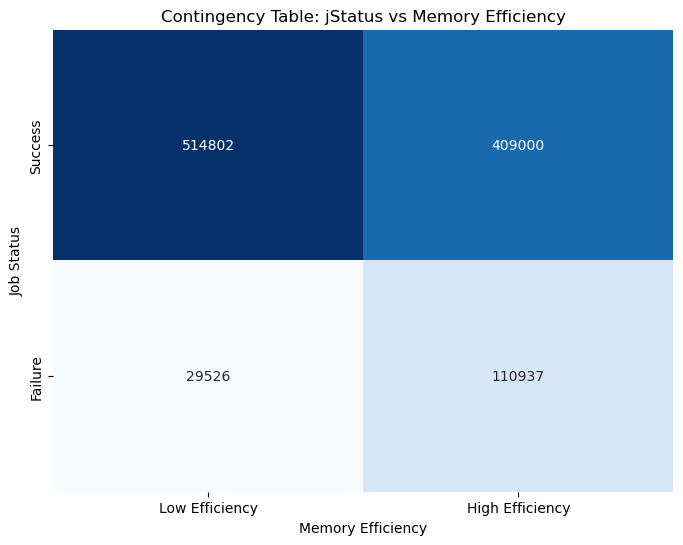

Chi-squared statistic: 58772.89880733256
p-value: 0.0
Degrees of freedom: 1
Expected frequencies:
[[472486.92295246 451315.07704754]
 [ 71841.07704754  68621.92295246]]


In [89]:
import pymongo
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact
import re

def mongo_connect(uri):
    try:
        client = pymongo.MongoClient(uri)
    except pymongo.errors.ConfigurationError:
        print("Invalid MongoDB URI")
        exit(1)
    except pymongo.errors.OperationFailure:
        print("Invalid MongoDB credentials")
        exit(1)
    return client

def extract_memory_efficiency_by_status(collection, start_time, end_time):
    # Query to match the submitTime and endTime criteria
    query = {
        "submitTime": { "$gt": start_time },
        "endTime": { "$lte": end_time }
    }
    
    # Extract the ratio of maxRMem to (requestedMemory * numProcessors) and group by jStatus
    success_data = []
    failure_data = []

    # Regular expression to extract the memory value from the resReq field
    mem_pattern = re.compile(r"mem=(\d+\.?\d*)")

    # Fetch maxRMem, resReq, numProcessors, and jStatus fields
    cursor = collection.find(query, {"maxRMem": 1, "resReq": 1, "numProcessors": 1, "jStatus": 1, "_id": 0})

    for document in cursor:
        if 'maxRMem' in document and 'resReq' in document and 'numProcessors' in document:
            max_rmem = document['maxRMem']
            res_req = document['resReq']
            num_processors = document['numProcessors']

            # Parse the requested memory from the resReq field
            match = mem_pattern.search(res_req)
            if match:
                requested_mem = float(match.group(1))  # Requested memory is in MB

                if requested_mem > 0:  # Avoid division by zero
                    # Adjust requested memory for the number of processors
                    requested_mem_adjusted = requested_mem * num_processors
                    
                    # Calculate memory efficiency
                    memory_efficiency = max_rmem / (requested_mem_adjusted * 1024)  # Convert requested memory to KB

                    if 'jStatus' in document:
                        if document['jStatus'] == 'done':
                            success_data.append(memory_efficiency)  # Success job memory efficiency
                        else:
                            failure_data.append(memory_efficiency)  # Failed job memory efficiency

    return success_data, failure_data

def perform_fishers_exact_test(success_data, failure_data):
    # Define cutoff for high/low memory efficiency
    cutoff = 0.8
    
    # Create a 2x2 contingency table
    success_high = sum(efficiency > cutoff for efficiency in success_data)
    success_low = len(success_data) - success_high
    failure_high = sum(efficiency > cutoff for efficiency in failure_data)
    failure_low = len(failure_data) - failure_high
    
    table = np.array([[success_high, success_low],
                      [failure_high, failure_low]])
    
    # Perform Fisher's Exact Test
    _, p_value = fisher_exact(table, alternative='two-sided')
    
    return table, p_value

def plot_contingency_table(contingency_table):
    plt.figure(figsize=(8, 6))
    sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Low Efficiency', 'High Efficiency'], 
                yticklabels=['Success', 'Failure'])
    plt.title('Contingency Table: jStatus vs Memory Efficiency')
    plt.xlabel('Memory Efficiency')
    plt.ylabel('Job Status')
    plt.show()

def main():
    start_time = 1724043600  # Define the start time
    end_time = 1724648400    # Define the end time
    
    client = mongo_connect("mongodb://localhost:27017")
    db = client['lsf']
    collection = db['finished_jobs']
    
    # Extract memory efficiency data separated by job status
    success_data, failure_data = extract_memory_efficiency_by_status(collection, start_time, end_time)

    # Plot the contingency table
    plot_contingency_table(contingency_table)

if __name__ == "__main__":
    main()

# Perform Chi-squared test
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print(f'Chi-squared statistic: {chi2}')
print(f'p-value: {p_value}')
print(f'Degrees of freedom: {dof}')
print('Expected frequencies:')
print(expected)


# statistically significant association between job status and memory efficiency


Chi-squared statistic: 5.486412472266921
p-value: 0.01916482936008161
Degrees of freedom: 1
Expected frequencies:
[[ 72030.94156138 543007.05843862]
 [ 53900.05843862 406326.94156138]]


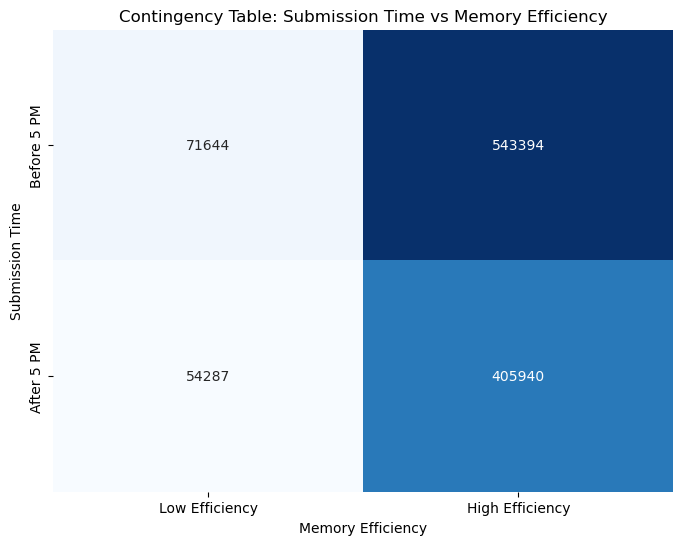

In [90]:
import pymongo
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import re
from datetime import datetime, timedelta
import pytz

def mongo_connect(uri):
    try:
        client = pymongo.MongoClient(uri)
    except pymongo.errors.ConfigurationError:
        print("Invalid MongoDB URI")
        exit(1)
    except pymongo.errors.OperationFailure:
        print("Invalid MongoDB credentials")
        exit(1)
    return client

def extract_memory_efficiency_by_time(collection, start_time, end_time):
    # Query to match the submitTime and endTime criteria
    query = {
        "submitTime": { "$gt": start_time },
        "endTime": { "$lte": end_time }
    }
    
    # Extract the ratio of maxRMem to (requestedMemory * numProcessors) and group by submission time
    before_5pm_data = []
    after_5pm_data = []

    # Regular expression to extract the memory value from the resReq field
    mem_pattern = re.compile(r"mem=(\d+\.?\d*)")

    # Fetch maxRMem, resReq, numProcessors, submitTime fields
    cursor = collection.find(query, {"maxRMem": 1, "resReq": 1, "numProcessors": 1, "submitTime": 1, "_id": 0})

    for document in cursor:
        if 'maxRMem' in document and 'resReq' in document and 'numProcessors' in document and 'submitTime' in document:
            max_rmem = document['maxRMem']
            res_req = document['resReq']
            num_processors = document['numProcessors']
            submit_time = document['submitTime']

            # Parse the requested memory from the resReq field
            match = mem_pattern.search(res_req)
            if match:
                requested_mem = float(match.group(1))  # Requested memory is in MB

                if requested_mem > 0:  # Avoid division by zero
                    # Adjust requested memory for the number of processors
                    requested_mem_adjusted = requested_mem * num_processors
                    
                    # Calculate memory efficiency
                    memory_efficiency = max_rmem / (requested_mem_adjusted * 1024)  # Convert requested memory to KB

                    # Convert submitTime from epoch to datetime and localize to UTC
                    submit_time = datetime.fromtimestamp(submit_time, tz=pytz.UTC)

                    # Determine if the submission is before or after 5 PM
                    if submit_time.hour < 17:
                        before_5pm_data.append(memory_efficiency)
                    else:
                        after_5pm_data.append(memory_efficiency)

    return before_5pm_data, after_5pm_data

def perform_chi_squared_test(before_5pm_data, after_5pm_data):
    # Define cutoff for high/low memory efficiency
    cutoff = 0.8
    
    # Create a 2x2 contingency table
    before_5pm_high = sum(efficiency > cutoff for efficiency in before_5pm_data)
    before_5pm_low = len(before_5pm_data) - before_5pm_high
    after_5pm_high = sum(efficiency > cutoff for efficiency in after_5pm_data)
    after_5pm_low = len(after_5pm_data) - after_5pm_high
    
    table = np.array([[before_5pm_high, before_5pm_low],
                      [after_5pm_high, after_5pm_low]])
    
    # Perform Chi-squared Test
    chi2, p_value, dof, expected = chi2_contingency(table)
    
    return table, chi2, p_value, dof, expected

def plot_contingency_table(contingency_table):
    plt.figure(figsize=(8, 6))
    sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Low Efficiency', 'High Efficiency'], 
                yticklabels=['Before 5 PM', 'After 5 PM'])
    plt.title('Contingency Table: Submission Time vs Memory Efficiency')
    plt.xlabel('Memory Efficiency')
    plt.ylabel('Submission Time')
    plt.show()

def main():
    start_time = 1724043600  # Define the start time
    end_time = 1724648400    # Define the end time
    
    client = mongo_connect("mongodb://localhost:27017")
    db = client['lsf']
    collection = db['finished_jobs']
    
    # Extract memory efficiency data separated by submission time
    before_5pm_data, after_5pm_data = extract_memory_efficiency_by_time(collection, start_time, end_time)

    # Perform Chi-squared test
    contingency_table, chi2, p_value, dof, expected = perform_chi_squared_test(before_5pm_data, after_5pm_data)
    
    # Print results
    print(f'Chi-squared statistic: {chi2}')
    print(f'p-value: {p_value}')
    print(f'Degrees of freedom: {dof}')
    print('Expected frequencies:')
    print(expected)
    
    # Plot the contingency table
    plot_contingency_table(contingency_table)

if __name__ == "__main__":
    main()
